##### Object Detection using TAO FasterRCNN

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/embedded-transfer-learning-toolkit-software-stack-1200x670px.png" width="1080"> 

 ## Learning Objectives
In this notebook, you will learn how to leverage the simplicity and convenience of TAO to:

* Take a pretrained resnet18 model and train a ResNet-18 FasterRCNN model on the KITTI dataset
* Prune the trained FasterRCNN model
* Retrain the pruned model to recover lost accuracy
* Run evaluation & inference on the trained model to verify the accuracy
* Export & deploy the model in DeepStream/TensorRT
* Quantization-Aware Training(QAT) workflow for the best accuracy-performance trade-off
 
 ### Table of Contents

 This notebook shows an example usecase of FasterRCNN using Train Adapt Optimize (TAO) Toolkit.

 0. [Set up env variables and map drives](#head-0)
 1. [Install the TAO launcher](#head-1)
 2. [Prepare dataset and pretrained model](#head-2)<br>
     2.1 [Download the dataset](#head-2-1)<br>
     2.2 [Verify the downloaded dataset](#head-2-2)<br>
     2.3 [Prepare tfrecords from kitti format dataset](#head-2-3)<br>
     2.4 [Download pretrained model](#head-2-4)
 3. [Provide training specification](#head-3)
 4. [Run TAO training](#head-4)
 5. [Evaluate trained models](#head-5)
 6. [Prune trained models](#head-6)
 7. [Retrain pruned models](#head-7)
 8. [Evaluate retrained model](#head-8)
 9. [Visualize inferences](#head-9)
 10. [Deploy](#head-10)
 11. [QAT workflow](#head-11)<br>
     11.1 [Training](#head-11.1)<br>
     11.2 [Evaluation](#head-11.2)<br>
     11.3 [Pruning](#head-11.3)<br>
     11.4 [Retraining](#head-11.4)<br>
     11.5 [Evaluation of the retrained model](#head-11.5)<br>
     11.6 [Inference of the retrained model](#head-11.6)<br>
     11.7 [Deployment of the QAT model](#head-11.7)

 ## 1. Set up env variables and map drives <a class="anchor" id="head-0"></a>
 
The following notebook requires the user to set an env variable called the `$LOCAL_PROJECT_DIR` as the path to the users workspace. More information on how to set up the dataset and the supported steps in the TAO workflow are provided in the subsequent cells.

In [1]:
# Setting up env variables for cleaner command line commands.
import os

print("Please replace the variables with your own.")
%env GPU_INDEX=0
%env KEY=tlt

# Please define this local project directory that needs to be mapped to the TAO docker session.
%env LOCAL_PROJECT_DIR=/home/ubuntu/cv_samples_v1.2.0/faster_rcnn
os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "data"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "faster_rcnn"
)
%env USER_EXPERIMENT_DIR=/workspace/tao-experiments/faster_rcnn
%env DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data
# The sample spec files are present in the same path as the downloaded samples.
# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=~/tao-samples/faster_rcnn
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)
%env SPECS_DIR=/workspace/tao-experiments/faster_rcnn/specs

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR

Please replace the variables with your own.
env: GPU_INDEX=0
env: KEY=tlt
env: LOCAL_PROJECT_DIR=/home/ubuntu/cv_samples_v1.2.0/faster_rcnn
env: USER_EXPERIMENT_DIR=/workspace/tao-experiments/faster_rcnn
env: DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data
env: SPECS_DIR=/workspace/tao-experiments/faster_rcnn/specs
total 32
-rw-rw-r-- 1 ubuntu ubuntu  302 Oct 19 01:12 faster_rcnn_tfrecords_kitti_synth_test.txt
-rw-rw-r-- 1 ubuntu ubuntu  320 Oct 19 01:14 faster_rcnn_tfrecords_kitti_synth_train.txt
-rw-rw-r-- 1 ubuntu ubuntu 3987 Oct 19 01:19 default_spec_resnet18_synth_train_evalute.txt
-rw-rw-r-- 1 ubuntu ubuntu 3987 Oct 19 01:19 default_spec_resnet18_synth_train.txt
drwxrwxr-x 2 ubuntu ubuntu 4096 Oct 19 01:27 archive
-rw-rw-r-- 1 ubuntu ubuntu  293 Oct 19 13:06 faster_rcnn_tfrecords_kitti_real_test.txt
-rw-rw-r-- 1 ubuntu ubuntu  317 Oct 19 13:07 faster_rcnn_tfrecords_kitti_real_train.txt
-rw-rw-r-- 1 ubuntu ubuntu 3979 Oct 19 13:22 default_spec_resnet18_real_train.txt


The cell below maps the project directory on your local host to a workspace directory in the TAO docker instance, so that the data and the results are mapped from in and out of the docker. For more information please refer to the [launcher instance](https://docs.nvidia.com/tao/tao-toolkit/tao_launcher.html) in the user guide.

When running this cell on AWS, update the drive_map entry with the dictionary defined below, so that you don't have permission issues when writing data into folders created by the TAO docker.

```json
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tao-experiments"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        },
    ],
    "DockerOptions": {
        "user": "{}:{}".format(os.getuid(), os.getgid())
    },
    # set gpu index for tao-converter
    "Envs": [
        {"variable": "CUDA_VISIBLE_DEVICES", "value": os.getenv("GPU_INDEX")},
    ]
}
```

In [2]:
# Mapping up the local directories to the TAO docker.
import json
import os
mounts_file = os.path.expanduser("~/.tao_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tao-experiments"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        }
    ],
     "Envs": [
         {
             "variable": "CUDA_VISIBLE_DEVICES",
             "value": "0"
         }
     ],
     "DockerOptions": {
         "shm_size": "16G",
         "ulimits": {
             "memlock": -1,
             "stack": 67108864
         },
         "user": "1001:1001"
     }
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

In [3]:
!cat ~/.tao_mounts.json

{
    "Mounts": [
        {
            "source": "/home/ubuntu/cv_samples_v1.2.0/faster_rcnn",
            "destination": "/workspace/tao-experiments"
        },
        {
            "source": "/home/ubuntu/cv_samples_v1.2.0/faster_rcnn/specs",
            "destination": "/workspace/tao-experiments/faster_rcnn/specs"
        }
    ]
}

In [5]:
# View the versions of the TAO launcher
!tao info

Configuration of the TAO Toolkit Instance
dockers: ['nvidia/tao/tao-toolkit-tf', 'nvidia/tao/tao-toolkit-pyt', 'nvidia/tao/tao-toolkit-lm']
format_version: 1.0
toolkit_version: 3.21.08
published_date: 08/17/2021


 ## 2. Download and Prepare dataset

Create a data folder inside the root directory and download the synthetic and real datasets from the provided links.

Dataset is already formatted into train and test for both synthetic and real cases. 

We have 2 scenarios in the dataset i.e dataset with less complex background and dataset with complex background.


Following directory structure will be there according to the spec files. 

├── real_test
├── real_train_20
├── synthetic_test
├── synthetic_train


## 3 Prepare tfrecords from kitti format dataset <a class="anchor" id="head-2-3"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the dataset_convert 
* TFRecords only need to be generated once.

In [14]:
##### Creating a new directory for the output tfrecords dump.
!mkdir -p $LOCAL_DATA_DIR/tfrecords/kitti_trainval && rm -rf $LOCAL_DATA_DIR/tfrecords/kitti_trainval/*
#KITTI trainval
!tao faster_rcnn dataset_convert --gpu_index $GPU_INDEX -d $SPECS_DIR/faster_rcnn_tfrecords_kitti_synth_train.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_synthetic_train/kitti_synthetic_train

!tao faster_rcnn dataset_convert --gpu_index $GPU_INDEX -d $SPECS_DIR/faster_rcnn_tfrecords_kitti_synth_test.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_synthetic_test/kitti_synthetic_test

2021-11-11 07:32:47,963 [INFO] root: Registry: ['nvcr.io']
2021-11-11 07:32:48,045 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/ubuntu/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-11 07:32:54,442 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-11-11 07:32:54,465 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 10555	Val: 106
2021-11-11 07:32:54,465 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2021-11-11 07:32:54,471 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partit

2021-11-11 07:33:26,203 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


In [13]:
# Creating a new directory for the output tfrecords dump.
# !mkdir -p $LOCAL_DATA_DIR/tfrecords/kitti_trainval && rm -rf $LOCAL_DATA_DIR/tfrecords/kitti_trainval/*
#KITTI trainval
!tao faster_rcnn dataset_convert --gpu_index $GPU_INDEX -d $SPECS_DIR/faster_rcnn_tfrecords_kitti_real_train.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_real_train_20/kitti_real_train_20

!tao faster_rcnn dataset_convert --gpu_index $GPU_INDEX -d $SPECS_DIR/faster_rcnn_tfrecords_kitti_real_test.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_real_test/kitti_real_test

2021-10-19 14:41:58,108 [INFO] root: Registry: ['nvcr.io']
2021-10-19 14:41:58,190 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/ubuntu/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-10-19 14:42:05,093 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-10-19 14:42:05,093 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Creating output directory /workspace/tao-experiments/data/tfrecords/kitti_real_train_20
2021-10-19 14:42:05,094 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 194	Val: 1
2021-10-19 14:42:05,094 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while

2021-10-19 14:42:25,939 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


 ## 4 NGC CLI Instalaltion & Download pre-trained model <a class="anchor" id="head-2-4"></a>

In [20]:
## Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2021-11-11 07:36:42--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 13.249.38.69, 13.249.38.66, 13.249.38.126, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|13.249.38.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25122135 (24M) [application/zip]
Saving to: ‘/home/ubuntu/cv_samples_v1.2.0/faster_rcnn/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  23.96M  --.-KB/s    in 0.1s    

2021-11-11 07:36:42 (196 MB/s) - ‘/home/ubuntu/cv_samples_v1.2.0/faster_rcnn/ngccli/ngccli_cat_linux.zip’ saved [25122135/25122135]

Archive:  /home/ubuntu/cv_samples_v1.2.0/faster_rcnn/ngccli/ngccli_cat_linux.zip
  inflating: /home/ubuntu/cv_samples_v1.2.0/faster_rcnn/ngccli/ngc  
 extracting: /home/ubuntu/cv_samples_v1.2.0/faster_rcnn/ngccli/ngc.md5  


In [21]:
!ngc registry model list nvidia/tao/pretrained_object_detection*

+---------+---------+---------+---------+---------+---------+---------+---------+
| Name    | Reposit | Latest  | Applica | Framewo | Precisi | Last Mo | Permiss |
|         | ory     | Version | tion    | rk      | on      | dified  | ion     |
+---------+---------+---------+---------+---------+---------+---------+---------+
| TAO Pre | nvidia/ | cspdark | Object  | Transfe | FP32    | Sep 20, | unlocke |
| trained | tao/pre | net53   | Detecti | r Learn |         | 2021    | d       |
| Object  | trained |         | on      | ing     |         |         |         |
| Detecti | _object |         |         | Toolkit |         |         |         |
| on      | _detect |         |         |         |         |         |         |
|         | ion     |         |         |         |         |         |         |
+---------+---------+---------+---------+---------+---------+---------+---------+


In [22]:
# Download model from NGC.2 
!ngc registry model download-version nvidia/tao/pretrained_object_detection:resnet18

Downloaded 82.38 MB in 6s, Download speed: 13.71 MB/s               
----------------------------------------------------
Transfer id: pretrained_object_detection_vresnet18 Download status: Completed.
Downloaded local path: /home/ubuntu/cv_samples_v1.2.0/faster_rcnn/pretrained_object_detection_vresnet18
Total files downloaded: 1 
Total downloaded size: 82.38 MB
Started at: 2021-11-11 07:36:50.509177
Completed at: 2021-11-11 07:36:56.521048
Duration taken: 6s
----------------------------------------------------


In [23]:
# Copy weights to experiment directory.
!cp pretrained_object_detection_vresnet18/resnet_18.hdf5 $LOCAL_EXPERIMENT_DIR
!rm -rf pretrained_object_detection_vresnet18
!ls -rlt $LOCAL_EXPERIMENT_DIR22

total 13524
drwxrwxr-x  5 ubuntu ubuntu    4096 Oct 18 23:11 archive_train
-rw-rw-r--  1 ubuntu ubuntu 3759456 Oct 19 03:27 out_resnet18_synth_amp16.log
drwxrwxr-x  3 ubuntu ubuntu    4096 Oct 19 11:09 logs
drwxrwxr-x  4 ubuntu ubuntu    4096 Oct 19 13:22 specs
drwxrwxr-x  2 ubuntu ubuntu    4096 Oct 19 13:22 synthetic
-rw-rw-r--  1 ubuntu ubuntu  484802 Oct 19 13:55 out_resnet18_synth_fine_tune_amp16.log
-rw-rw-r--  1 ubuntu ubuntu  385864 Oct 19 15:05 out_resnet18_synth_fine_tune_10_amp16.log
drwxrwxr-x 11 ubuntu ubuntu    4096 Nov 11 07:13 data
drwxr-xr-x  4 ubuntu ubuntu    4096 Nov 11 07:28 faster_rcnn_
-rw-rw-r--  1 ubuntu ubuntu 9173235 Nov 11 07:36 faster_rcnn.ipynb
drwxrwxr-x  2 ubuntu ubuntu    4096 Nov 11 07:36 ngccli
drwxr-xr-x  3 ubuntu ubuntu    4096 Nov 11 07:36 faster_rcnn


 ## 5. Provide training specification <a class="anchor" id="head-3"></a>

In [24]:
!sed -i 's/$KEY/'"$KEY/g" $LOCAL_SPECS_DIR/default_spec_resnet18_synth_train.txt
!cat $LOCAL_SPECS_DIR/default_spec_resnet18_synth_train.txt

# Copyright (c) 2017-2020, NVIDIA CORPORATION.  All rights reserved.
random_seed: 42
enc_key: 'tlt'
verbose: True
model_config {
input_image_config {
image_type: RGB
image_channel_order: 'bgr'
size_height_width {
height: 512
width: 512
}
    image_channel_mean {
        key: 'b'
        value: 103.939
}
    image_channel_mean {
        key: 'g'
        value: 116.779
}
    image_channel_mean {
        key: 'r'
        value: 123.68
}
image_scaling_factor: 1.0
max_objects_num_per_image: 100
}
arch: "resnet:18"
anchor_box_config {
scale: 64.0
scale: 128.0
scale: 256.0
ratio: 1.0
ratio: 0.5
ratio: 2.0
}
freeze_bn: True
freeze_blocks: 0
freeze_blocks: 1
roi_mini_batch: 256
rpn_stride: 16
use_bias: False
roi_pooling_config {
pool_size: 7
pool_size_2x: False
}
all_projections: True
use_pooling:False
}
dataset_config {
  data_sources: {
    tfrecords_path: "/workspace/tao-experiments/data/tfrecords/kitti_synthetic_train/kitti_synthetic_train*"
    image_directory_path: "/workspace/tao-experim

 ## 6. Run TAO training on Synthetic Dataset<a class="anchor" id="head-4"></a>
 * Provide the sample spec file for training.

In [25]:
!tao faster_rcnn train --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_synth_train.txt --use_amp > out_resnet18_synth_amp16.log

2021-11-11 07:37:17,261 [INFO] root: Registry: ['nvcr.io']
2021-11-11 07:37:17,345 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/ubuntu/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
2021-11-11 10:30:41,194 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


In [ ]:
print('Model for each epoch:')
print('---------------------')
!ls -lht $LOCAL_EXPERIMENT_DIR

 ## 7. Evaluate trained models Synthetic Dataset <a class="anchor" id="head-5"></a>

In [ ]:
!echo $SPECS_DIR

In [13]:
!tao faster_rcnn evaluate --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_synth_train.txt

2021-10-19 11:15:13,770 [INFO] root: Registry: ['nvcr.io']
2021-10-19 11:15:13,924 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/ubuntu/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-10-19 11:15:23,896 [INFO] iva.faster_rcnn.spec_loader.spec_loader: Loading experiment spec at /workspace/tao-experiments/faster_rcnn/specs/default_spec_resnet18_synth_train.txt.

2021-10-19 11:15:23,900 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/evaluate.py:60: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto i


2021-10-19 11:15:34,187 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

2021-10-19 11:15:35,507 [INFO] __main__: Building evaluation model, may take a while...

2021-10-19 11:17:53,619 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-10-19 11:17:53,741 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp

time_distributed_4 (TimeDistrib (None, 300, 512, 7,  2048        time_distributed_3[0][0]         
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 300, 512, 7,  2048        time_distributed_5[0][0]         
__________________________________________________________________________________________________
add_7 (Add)                     (None, 300, 512, 7,  0           time_distributed_4[0][0]         
                                                                 time_distributed_6[0][0]         
__________________________________________________________________________________________________
block_4a_relu (Activation)      (None, 300, 512, 7,  0           add_7[0][0]                      
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 300, 512, 7,  2359296     block_4a_relu[0][0]              
__________


2021-10-19 11:17:56,855 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/core/build_wheel.runfiles/ai_infra/moduluspy/modulus/blocks/data_loaders/multi_source_loader/types/images2d_reference.py:427: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


2021-10-19 11:17:57,401 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/utils/utils.py:22: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.


2021-10-19 11:17:57,401 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/utils/utils.py:23: The 

 ## 8. Run TAO training or fine tuning on Real Dataset<a class="anchor" id="head-4"></a>
 * Provide the sample spec file for training.

In [14]:
!tao faster_rcnn train --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_real_train.txt --use_amp > out_resnet18_synth_fine_tune_10_amp16.log

2021-10-19 14:42:42,455 [INFO] root: Registry: ['nvcr.io']
2021-10-19 14:42:42,536 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/ubuntu/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
2021-10-19 15:05:54,955 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


 ## 9. Visualize inferences <a class="anchor" id="head-9"></a>
 In this section, we run the inference tool to generate inferences on the trained models.

In [20]:
# Running inference for detection on n images
# Please go to $LOCAL_EXPERIMENT_DIR/inference_results_imgs_retrain to see the visualizations.
!tao faster_rcnn inference --gpu_index $GPU_INDEX -e $SPECS_DIR/default_spec_resnet18_real_train.txt

2021-10-21 19:47:37,519 [INFO] root: Registry: ['nvcr.io']
2021-10-21 19:47:37,598 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/ubuntu/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.

2021-10-21 19:47:44,202 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/faster_rcnn/scripts/inference.py:52: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2021-10-21 19:47:44,202 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packa


2021-10-21 19:47:51,737 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

2021-10-21 19:47:52,565 [INFO] __main__: Building inference model, may take a while...

2021-10-21 19:49:24,705 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-10-21 19:49:24,800 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpu

100%|███████████████████████████████████████████| 91/91 [01:29<00:00,  1.01it/s]
2021-10-21 19:50:56,072 [INFO] __main__: Inference output images directory: /workspace/tao-experiments/faster_rcnn/inference_results_imgs
2021-10-21 19:50:56,072 [INFO] __main__: Inference output labels directory: /workspace/tao-experiments/faster_rcnn/inference_dump_labels
2021-10-21 19:50:58,277 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


The `inference` tool produces two outputs. 
1. Overlain images in `$LOCAL_EXPERIMENT_DIR/inference_results_imgs_retrain`
2. Frame by frame bbox labels in kitti format located in `$LOCAL_EXPERIMENT_DIR/inference_dump_labels_retrain`

In [17]:
# Simple grid visualizer
!pip3 install matplotlib==3.3.3
%matplotlib inline
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


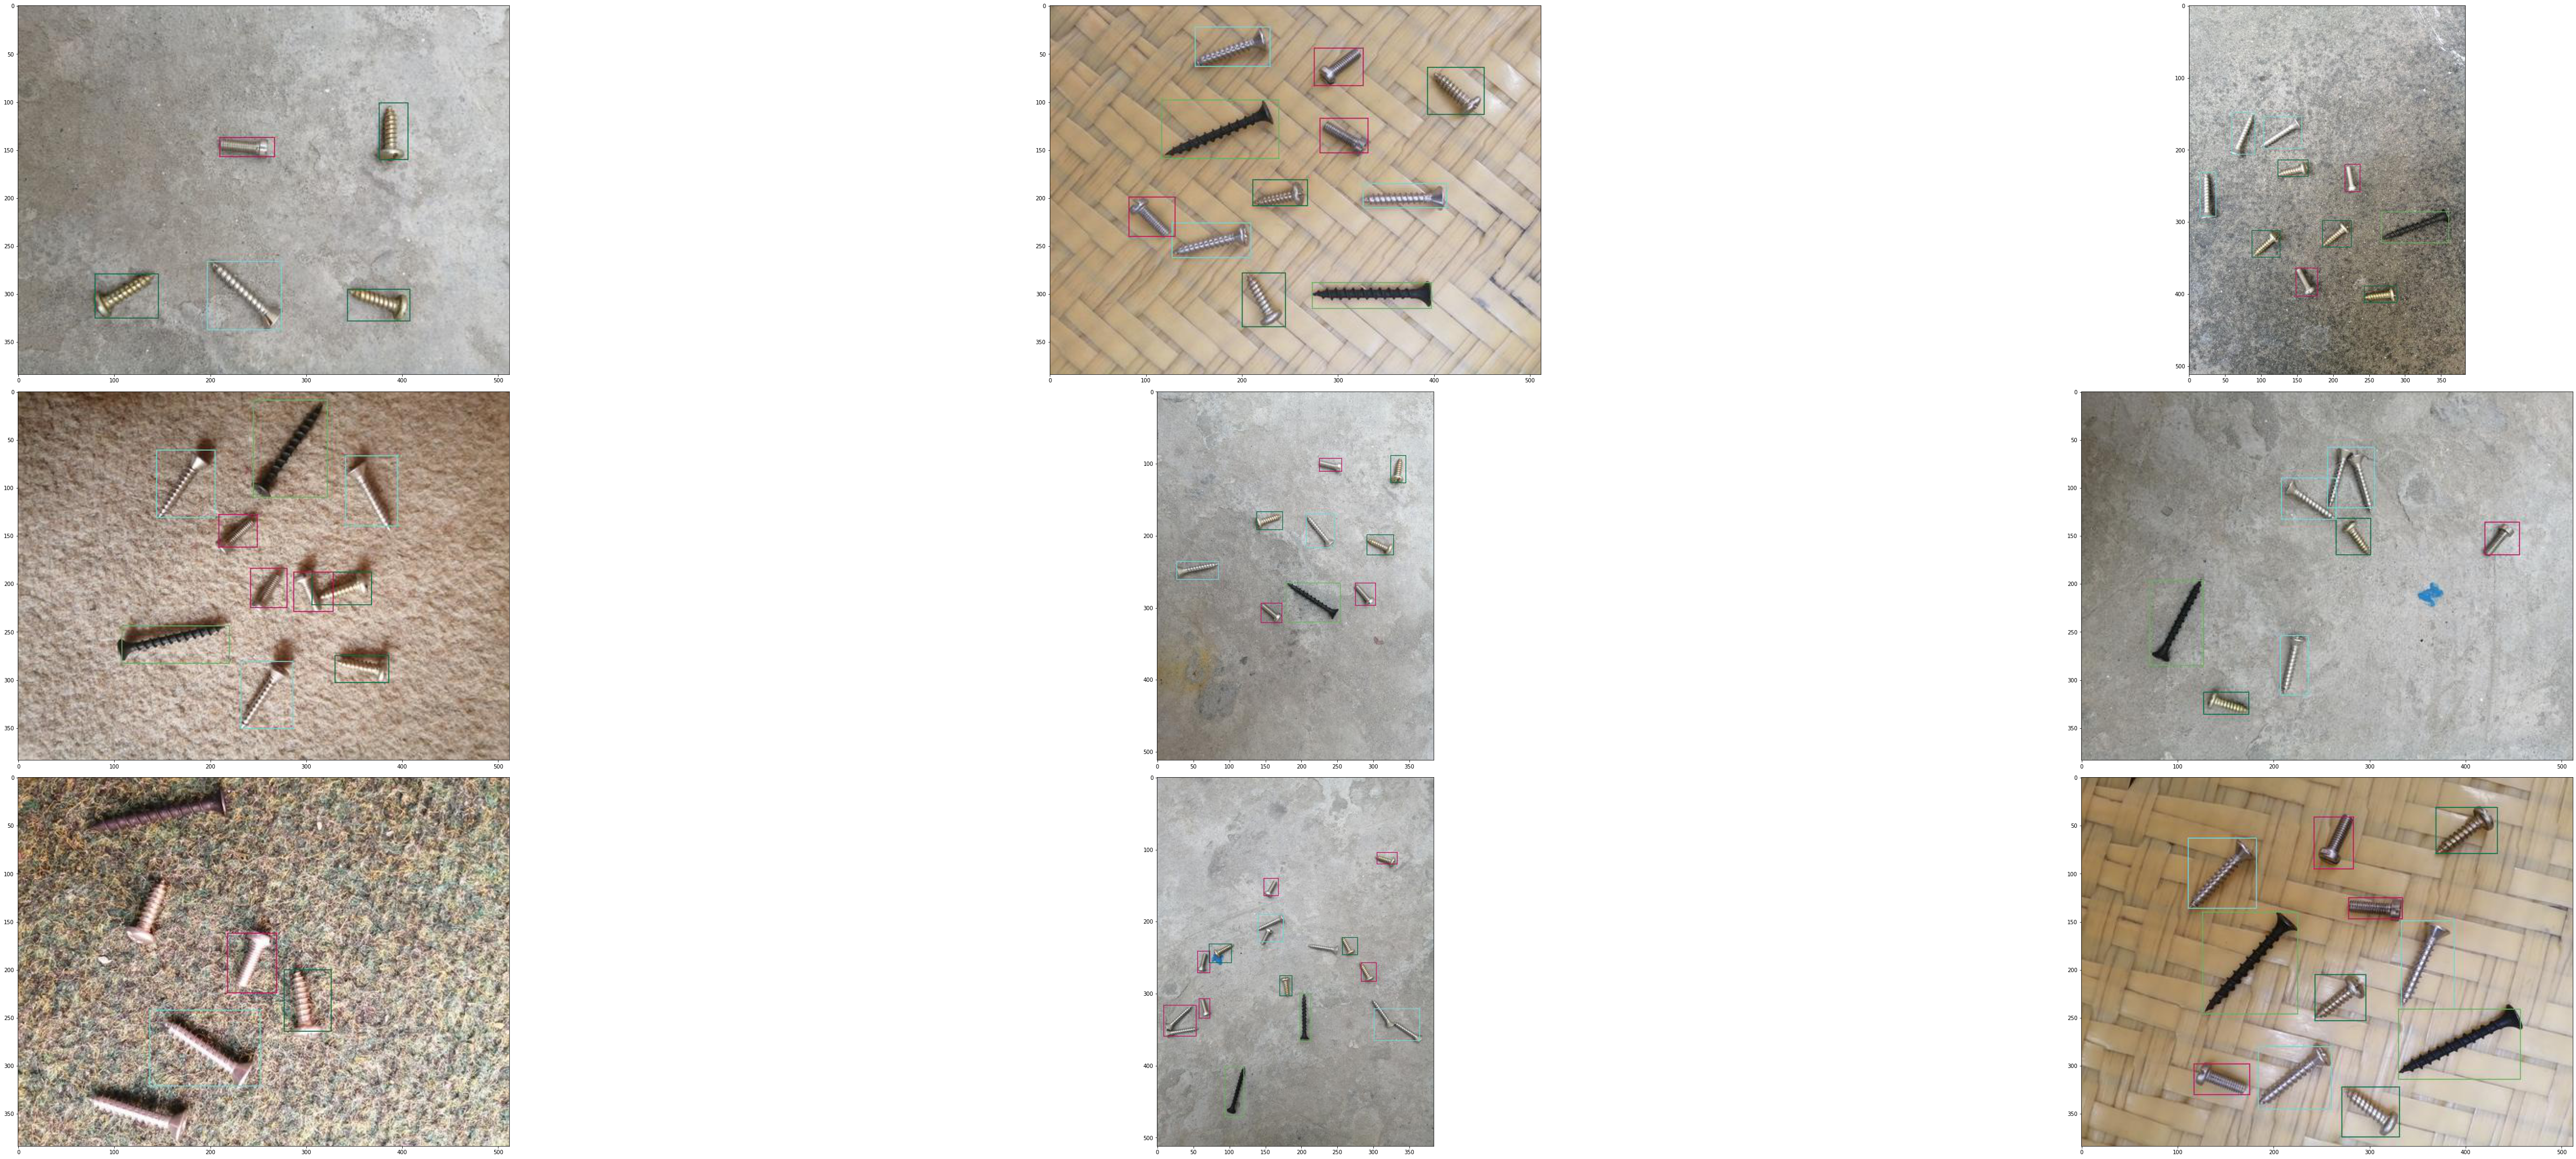

In [19]:
# Visualizing the sample images.
OUTPUT_PATH = 'inference_results_imgs' # relative path from $LOCAL_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 9 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)